# Business Problem

A house buyer assigns me a task about the house in King County. He wants to buy a house in this area but doesn't have any ideas about the housing market. And he has some preferred features in his mind, he wants to have a predicted price so that he can prepare for that.

# Plan

In this business problem, I will use King County House Sales dataset to analyze. Base on this situation, I am planning give him a overview about the house market and how the footage of the home(sqft_living) affect the price. At last, I will make a prediction of price with his prefer features using model. Therefore, I divide this issue into three parts.

### What features do he need to concern about?
    * Find the most related features with the price.
### How the footage of the home (sqft_living) affect the price?
    * Find the correlation between them and the regression model.
### How much should he prepare for the dream house?
    *Find the prediction of price with model.

# EDA (Exploratory data analysis)

## Import and Preview

In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import scipy.stats as stats
from haversine import haversine, Unit

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import dataset
df = pd.read_csv("/Users/jrchen/flatiron-ds-course/Milestones/dsc-phase-2-project-online/Phase-2-Project/data/clean_data.csv")

### Column Names and descriptions for Kings County Data Set

id - unique identified for a house\
dateDate - house was sold\
pricePrice - is prediction target\
bedroomsNumber - of Bedrooms/House\
bathroomsNumber - of bathrooms/bedrooms\
sqft_livingsquare - footage of the home\
sqft_lotsquare - footage of the lot\
floorsTotal - floors (levels) in house\
waterfront - House which has a view to a waterfront\
view - Has been viewed\
condition - How good the condition is ( Overall )\
grade - overall grade given to the housing unit, based on King County grading system\
sqft_above - square footage of house apart from basement\
sqft_basement - square footage of the basement\
yr_built - Built Year\
yr_renovated - Year when house was renovated\
zipcode - zip\
lat - Latitude coordinate\
long - Longitude coordinate\
sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors\
sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [3]:
df.drop(columns=['Unnamed: 0', 'id', 'date'], inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,basement_exist,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,604000.0,4,3.0,1960,5000,1.0,5,7,1050,1.0,1965,98136,47.5208,-122.393,1360,5000
1,510000.0,3,2.0,1680,8080,1.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503
2,229500.0,3,1.0,1780,7470,1.0,3,7,1050,1.0,1960,98146,47.5123,-122.337,1780,8113
3,323000.0,3,2.5,1890,6560,2.0,3,7,1890,0.0,2003,98038,47.3684,-122.031,2390,7570
4,468000.0,2,1.0,1160,6000,1.0,4,7,860,1.0,1942,98115,47.6900,-122.292,1330,6000


## distance (base on long and lat) instead of zip code:

### Normalization

In [4]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [5]:
# Before doing the normalizaiton, let check the r square 
forward_selected(df, 'price').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     1297.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:39:56   Log-Likelihood:            -1.2996e+05
No. Observations:               10013   AIC:                         2.599e+05
Df Residuals:                    9998   BIC:                         2.601e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5.151e+06   2.27e+06      2.272      0.023    7.07e+05     9.6e+06
lat             5.364e+05   8032.540     66.783      0.000    5.21e+05    5.52e+05
sqft_living       52.8645      6.046      8.743      0.000      41.013      64.716
grade            7.46e+04   2013.141     37.058      0.000    7.07e+04    7.85e+04
yr_built       -1951.1588     55.660    -35.055      0.000   -2060.264   -1842.054
sqft_lot15        -5.5379      0.814     -6.800      0.000      -7.134      -3.942
condition       2.764e+04   1801.872     15.337      0.000    2.41e+04    3.12e+04
sqft_living15     42.7475      3.573     11.964      0.000      35.743      49.752
zipcode         -277.7260     23.274    -11.933      0.000    -323.348    -232.104
bathrooms       1.538e+04   2759.987      5.572      0.000    9969.241    2.08e+04
bedrooms       -9845.6481   1793.092     -5.491      0.000   -1.34e+04   -6330.826
sqft_lot          -3.2963      0.712     -4.632      0.000      -4.691      -1.901
floors          9973.0482   3219.491      3.098      0.002    3662.198    1.63e+04
basement_exist  3.428e+04   4304.310      7.963      0.000    2.58e+04    4.27e+04
sqft_above        49.2184      6.688      7.359      0.000      36.108      62.328
==============================================================================
Omnibus:                     1203.886   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2505.662
Skew:                           0.750   Prob(JB):                         0.00
Kurtosis:                       4.938   Cond. No.                     2.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Set the mean of the lat and long of the highest price house as a base. And I will calculate the distance to the lat and long as a new feature instead of zip code.

In [6]:
df.loc[df['price'] == df['price'].max()].describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,basement_exist,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.0,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000
mean,1110000.0,4.400000,2.750000,2902.000000,6438.000000,1.600000,3.600000,8.20000,2148.000000,1.0,1984.00000,98067.000000,47.62922,-122.267200,2158.000000,6481.600000
std,0.0,0.547723,0.790569,391.049869,4480.035714,0.547723,0.894427,0.83666,228.407531,0.0,27.86575,57.109544,0.02664,0.074469,471.189983,4177.219745
min,1110000.0,4.000000,1.500000,2310.000000,2650.000000,1.000000,3.000000,7.00000,1890.000000,1.0,1950.00000,98004.000000,47.59320,-122.354000,1620.000000,2960.000000
25%,1110000.0,4.000000,2.500000,2770.000000,3600.000000,1.000000,3.000000,8.00000,2060.000000,1.0,1959.00000,98005.000000,47.62170,-122.309000,1820.000000,3904.000000
50%,1110000.0,4.000000,3.000000,2990.000000,4000.000000,2.000000,3.000000,8.00000,2100.000000,1.0,1997.00000,98105.000000,47.62320,-122.291000,2240.000000,4000.000000
75%,1110000.0,5.000000,3.250000,3090.000000,8640.000000,2.000000,4.000000,9.00000,2180.000000,1.0,2000.00000,98109.000000,47.64350,-122.210000,2270.000000,8800.000000
max,1110000.0,5.000000,3.500000,3350.000000,13300.000000,2.000000,5.000000,9.00000,2510.000000,1.0,2014.00000,98112.000000,47.66450,-122.172000,2840.000000,12744.000000


In [7]:
# a function to calcualte the distance base on lat and long
def to_distance(lat, long):
    base = (47.62922, -122.267200) # (lat, long)
    house = (lat, long)

    #haversine(base, house) in kilometers

    return haversine(base, house, unit=Unit.MILES)

In [8]:
# apply that for every row
df['distance'] = None
for i in range(df.shape[0]):
    df['distance'][i] = to_distance(df['lat'][i], df['long'][i])
df = df.astype({'distance': 'float64'})
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,basement_exist,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,distance
0,604000.0,4,3.0,1960,5000,1.0,5,7,1050,1.0,1965,98136,47.5208,-122.393,1360,5000,9.513193
1,510000.0,3,2.0,1680,8080,1.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,10.383231
2,229500.0,3,1.0,1780,7470,1.0,3,7,1050,1.0,1960,98146,47.5123,-122.337,1780,8113,8.709059
3,323000.0,3,2.5,1890,6560,2.0,3,7,1890,0.0,2003,98038,47.3684,-122.031,2390,7570,21.126323
4,468000.0,2,1.0,1160,6000,1.0,4,7,860,1.0,1942,98115,47.6900,-122.292,1330,6000,4.355199


In [9]:
df.drop(columns=['zipcode'], inplace=True)
forward_selected(df, 'price').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1571.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:40:03   Log-Likelihood:            -1.2932e+05
No. Observations:               10013   AIC:                         2.587e+05
Df Residuals:                    9998   BIC:                         2.588e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.339e+07   1.53e+06      8.769      0.000    1.04e+07    1.64e+07
distance       -1.212e+04    313.912    -38.624      0.000   -1.27e+04   -1.15e+04
sqft_living       48.4719      5.618      8.628      0.000      37.459      59.485
grade           6.646e+04   1910.889     34.780      0.000    6.27e+04    7.02e+04
yr_built       -1330.7364     54.149    -24.576      0.000   -1436.879   -1224.594
long            1.467e+05   1.07e+04     13.731      0.000    1.26e+05    1.68e+05
condition        2.98e+04   1681.037     17.727      0.000    2.65e+04    3.31e+04
sqft_lot15        -3.6612      0.752     -4.868      0.000      -5.136      -2.187
sqft_living15     40.5209      3.358     12.069      0.000      33.939      47.102
lat             1.454e+05   1.21e+04     11.972      0.000    1.22e+05    1.69e+05
sqft_above        63.0885      6.067     10.399      0.000      51.196      74.981
basement_exist  2.695e+04   4045.349      6.663      0.000     1.9e+04    3.49e+04
bedrooms       -1.079e+04   1682.219     -6.413      0.000   -1.41e+04   -7490.567
bathrooms       1.604e+04   2524.197      6.355      0.000    1.11e+04     2.1e+04
sqft_lot          -1.3583      0.665     -2.043      0.041      -2.662      -0.055
==============================================================================
Omnibus:                      925.740   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1662.438
Skew:                           0.647   Prob(JB):                         0.00
Kurtosis:                       4.521   Cond. No.                     1.70e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

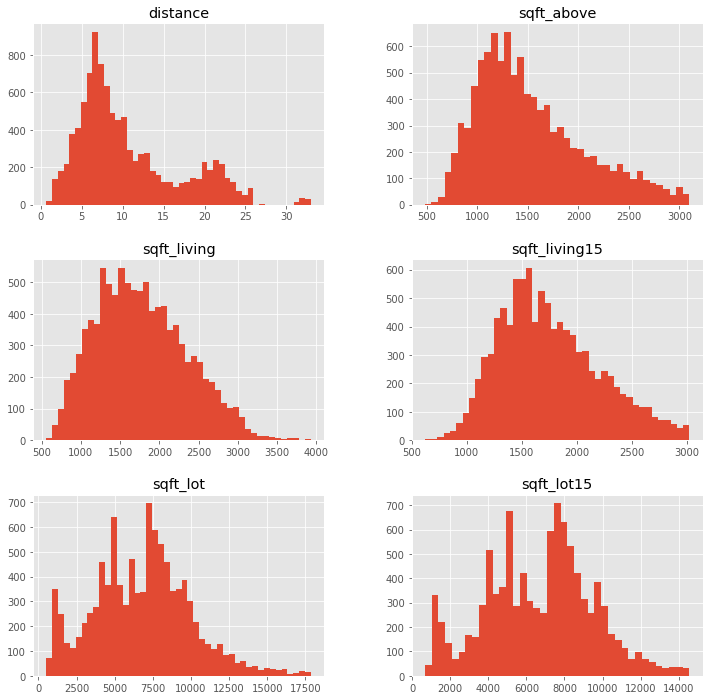

In [10]:
# Select non zero-inflated continuous features as df_cont base on the hist graph and other features stroe in df_others
df_cont = df[['sqft_living', 'sqft_lot',  'sqft_above',  'sqft_living15', 'sqft_lot15', 'distance']]
df_int = df[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_built']]
df_cat = df['basement_exist']
df_cont.hist(figsize=(12,12), bins='auto')
plt.show()

### Model 1: Non-transformation

In [11]:
df_final = pd.concat([df['price'], df_cont, df_int, df_cat], axis=1)
df_final.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_living15,sqft_lot15,distance,bedrooms,bathrooms,floors,condition,grade,yr_built,basement_exist
0,604000.0,1960,5000,1050,1360,5000,9.513193,4,3.0,1.0,5,7,1965,1.0
1,510000.0,1680,8080,1680,1800,7503,10.383231,3,2.0,1.0,3,8,1987,0.0
2,229500.0,1780,7470,1050,1780,8113,8.709059,3,1.0,1.0,3,7,1960,1.0
3,323000.0,1890,6560,1890,2390,7570,21.126323,3,2.5,2.0,3,7,2003,0.0
4,468000.0,1160,6000,860,1330,6000,4.355199,2,1.0,1.0,4,7,1942,1.0


In [12]:
# vif function to get a list of high vif features
def vif_over(df, value, response):
    vif_list = []
    X = df.drop(columns=[response])
    X = add_constant(X)
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for i in list(zip(X, vif)):
        if i[1] > value:
            vif_list.append(i)
    return vif_list

The Variance Inflation Factor (VIF) is 1/Tolerance, it is always greater than or equal to 1. There is no formal VIF value for determining presence of multicollinearity. Values of VIF that exceed 10 are often regarded as indicating multicollinearity, but in weaker models values above 2.5 may be a cause for concern.

However, I will use 3.5 as a upper bond here because I don't want to drop any zip code columns

In [13]:
# a while loop function thta drop the highest vif each time until all vif in the range we set except intercept
def drop_high_vif(df, value, response):
    while (len(vif_over(df, value, response)) > 1):
        vif_list = vif_over(df, value, response)
        if vif_list[0][0] == 'const':
            vif_list.pop(0)
        drop = vif_list[0]
        for n in vif_list:
            if n[1] > drop[1]:
                drop = n
        df_final.drop(columns=[drop[0]], inplace=True)

In [14]:
drop_high_vif(df_final, 3.5, 'price')

#### Validation

In [15]:
# a function to calculate the mse of train set and test set
# also plot the qq-plot
def test(df, response):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[response]), 
                                                    df[response], test_size=0.2)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squared Error:', train_mse)
    print('Test Mean Squared Error:', test_mse)
    sm.graphics.qqplot(train_residuals, dist=stats.norm, line='45', fit=True)
    plt.show()

Train Mean Squared Error: 11110067996.111124
Test Mean Squared Error: 10658766992.5509


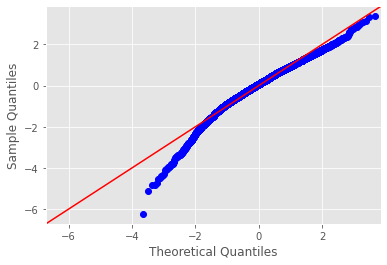

In [16]:
test(df_final, 'price')

In [17]:
# cross valiation
def cross_valiation(df, response):
    X = df_final.drop(columns=[response])
    y = df_final[response]
    mse = make_scorer(mean_squared_error)
    linreg = LinearRegression()
    cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
    return cv_5_results.mean()

In [18]:
#cross_valiation(df_final, 'price')

In [19]:
m = forward_selected(df_final, 'price')
print('Mean Residuals is: {}'.format(m.resid.abs().mean()))
m.summary()

Mean Residuals is: 80840.24297000362


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1808.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:40:08   Log-Likelihood:            -1.2997e+05
No. Observations:               10013   AIC:                         2.600e+05
Df Residuals:                   10002   BIC:                         2.600e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.136e+06   1.08e+05     19.765      0.000    1.92e+06    2.35e+06
distance       -1.423e+04    200.901    -70.838      0.000   -1.46e+04   -1.38e+04
grade            8.07e+04   1951.077     41.360      0.000    7.69e+04    8.45e+04
sqft_living15     92.4731      3.157     29.295      0.000      86.286      98.661
condition       3.004e+04   1777.729     16.900      0.000    2.66e+04    3.35e+04
yr_built       -1286.1723     56.310    -22.841      0.000   -1396.551   -1175.793
bathrooms       4.031e+04   2629.322     15.330      0.000    3.52e+04    4.55e+04
floors          1.622e+04   3026.971      5.358      0.000    1.03e+04    2.22e+04
bedrooms        7268.2736   1638.215      4.437      0.000    4057.042    1.05e+04
basement_exist  5651.6925   2574.288      2.195      0.028     605.571    1.07e+04
sqft_lot          -0.6589      0.424     -1.555      0.120      -1.489       0.171
==============================================================================
Omnibus:                      880.507   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1454.237
Skew:                           0.649   Prob(JB):                         0.00
Kurtosis:                       4.342   Cond. No.                     8.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2: Log transformations and Standardize

### Log transformations

In [20]:
def log(df):
    log_names = [f'{column}_log' for column in df.columns]

    df_log = np.log(df_cont)
    df_log.columns = log_names
#    df_log.hist(figsize=(10, 10), bins='auto')
#    plt.show()
    return df_log

In [21]:
df_log = log(df_cont)

### Standardize

In [22]:
# create a normalize function that apply to each feature
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

df_log_nor = df_log.apply(normalize)
df_int_nor = df_int.apply(normalize)
#df_log_nor.hist(figsize  = [8, 8]);

In [23]:
# concat the transfromation features with other features and this will be our new transformation data
df_final = pd.concat([df['price'], df_log_nor, df_cat, df_int_nor], axis=1)
df_final.head()

,price,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_living15_log,sqft_lot15_log,distance_log,basement_exist,bedrooms,bathrooms,floors,condition,grade,yr_built
0,604000.0,0.461458,-0.275873,-0.940504,-0.843427,-0.321650,0.103864,1.0,0.981171,1.613506,-0.828840,2.368737,-0.443236,-0.190089
1,510000.0,0.002613,0.519625,0.444141,0.233364,0.418966,0.248911,0.0,-0.319394,0.063283,-0.828840,-0.663888,0.839088,0.563082
2,229500.0,0.174719,0.389521,-0.940504,0.190441,0.561600,-0.042514,1.0,-0.319394,-1.486940,-0.828840,-0.663888,-0.443236,-0.361265
3,323000.0,0.353206,0.174211,0.791133,1.322466,0.435189,1.426238,0.0,-0.319394,0.838395,0.996759,-0.663888,-0.443236,1.110842
4,468000.0,-1.099840,0.026315,-1.528569,-0.929116,0.011048,-1.191111,1.0,-1.619958,-1.486940,-0.828840,0.852424,-0.443236,-0.977496


In [24]:
# vif
drop_high_vif(df_final, 3.5, 'price')

Train Mean Squared Error: 9534402926.103527
Test Mean Squared Error: 9531588843.911503


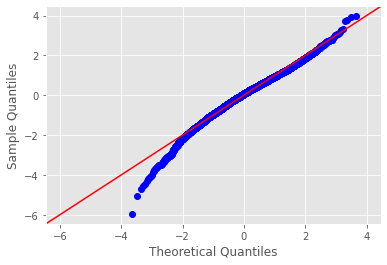

In [25]:
test(df_final, 'price')

In [26]:
#cross_valiation(df_final, 'price_log')

In [27]:
m = forward_selected(df_final, 'price')
print('Mean Residuals is: {}'.format(m.resid.abs().mean()))
m.summary()

Mean Residuals is: 75706.54494344277


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     2042.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:40:11   Log-Likelihood:            -1.2925e+05
No. Observations:               10013   AIC:                         2.585e+05
Df Residuals:                   10001   BIC:                         2.586e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.172e+05   1433.838    290.994      0.000    4.14e+05     4.2e+05
distance_log       -1.06e+05   1268.302    -83.579      0.000   -1.08e+05   -1.04e+05
sqft_above_log     6.192e+04   1989.507     31.125      0.000     5.8e+04    6.58e+04
grade              4.628e+04   1484.819     31.165      0.000    4.34e+04    4.92e+04
condition          1.984e+04   1089.978     18.205      0.000    1.77e+04     2.2e+04
basement_exist      3.97e+04   2750.624     14.434      0.000    3.43e+04    4.51e+04
sqft_living15_log  2.005e+04   1458.453     13.747      0.000    1.72e+04    2.29e+04
yr_built          -1.918e+04   1592.750    -12.041      0.000   -2.23e+04   -1.61e+04
bathrooms          1.166e+04   1644.322      7.091      0.000    8437.448    1.49e+04
floors            -6901.1521   1722.451     -4.007      0.000   -1.03e+04   -3524.801
bedrooms          -6793.5965   1250.458     -5.433      0.000   -9244.745   -4342.448
sqft_lot15_log     3995.3085   1479.047      2.701      0.007    1096.079    6894.538
==============================================================================
Omnibus:                      463.121   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              726.909
Skew:                           0.408   Prob(JB):                    1.42e-158
Kurtosis:                       4.037   Cond. No.                         6.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3: Log transformation and Min-max Scaling

### Min-max Scaling

In [28]:
# create a min-max scaling function that apply to each feature
def minmax(feature):
    return (feature-feature.min()) / (feature.max()-feature.min())

df_log_mm = df_log.apply(minmax)
df_int_mm = df_int.apply(minmax)

In [29]:
# concat the transfromation features with other features and this will be our new transformation data
df_final = pd.concat([df['price'], df_log_mm, df_int_mm, df_cat], axis=1)
df_final.head()

,price,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_living15_log,sqft_lot15_log,distance_log,bedrooms,bathrooms,floors,condition,grade,yr_built,basement_exist
0,604000.0,0.642951,0.640013,0.419627,0.496131,0.654589,0.680640,0.666667,0.714286,0.0,1.000000,0.333333,0.565217,1.0
1,510000.0,0.563837,0.775730,0.671589,0.673168,0.785691,0.703111,0.333333,0.428571,0.0,0.333333,0.666667,0.756522,0.0
2,229500.0,0.593511,0.753533,0.419627,0.666111,0.810940,0.657964,0.333333,0.142857,0.0,0.333333,0.333333,0.521739,1.0
3,323000.0,0.624286,0.716800,0.734731,0.852230,0.788563,0.885500,0.333333,0.571429,0.4,0.333333,0.333333,0.895652,0.0
4,468000.0,0.373751,0.691568,0.312617,0.482043,0.713482,0.480025,0.000000,0.142857,0.0,0.666667,0.333333,0.365217,1.0


In [30]:
drop_high_vif(df_final, 3.5, 'price')

Train Mean Squared Error: 10386628299.195896
Test Mean Squared Error: 10742839512.297537


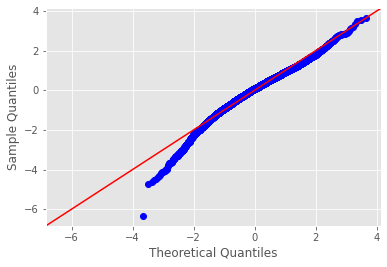

In [31]:
test(df_final, 'price')

In [32]:
#cross_valiation(df_final, 'price_log')

In [33]:
m = forward_selected(df_final, 'price')
print('Mean Residuals is: {}'.format(m.resid.abs().mean()))
m.summary()

Mean Residuals is: 78490.80390278941


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     2178.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:40:14   Log-Likelihood:            -1.2971e+05
No. Observations:               10013   AIC:                         2.594e+05
Df Residuals:                   10003   BIC:                         2.595e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.169e+05   7083.052     72.972      0.000    5.03e+05    5.31e+05
distance_log      -6.551e+05   8357.642    -78.385      0.000   -6.71e+05   -6.39e+05
grade              2.339e+05   5678.265     41.193      0.000    2.23e+05    2.45e+05
sqft_living15_log  2.193e+05   8690.649     25.236      0.000    2.02e+05    2.36e+05
condition           8.71e+04   5191.189     16.779      0.000    7.69e+04    9.73e+04
bathrooms          1.399e+05   8532.274     16.396      0.000    1.23e+05    1.57e+05
yr_built          -1.009e+05   6504.828    -15.510      0.000   -1.14e+05   -8.81e+04
sqft_lot15_log     7.248e+04   8324.643      8.707      0.000    5.62e+04    8.88e+04
floors             3.818e+04   6981.057      5.469      0.000    2.45e+04    5.19e+04
bedrooms           2.425e+04   4789.803      5.063      0.000    1.49e+04    3.36e+04
==============================================================================
Omnibus:                      716.636   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1209.656
Skew:                           0.546   Prob(JB):                    2.12e-263
Kurtosis:                       4.307   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Future Work

## interactions

In [ ]:
#feat_combinations = combinations(X.columns, 2)

In [ ]:
#regression = LinearRegression()

In [ ]:
#crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
#baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
#baseline

In [ ]:
## code to find top interactions by R^2 value here
#interaction={}
#data = X.copy()
#for (a,b) in feat_combinations:
#    data['interaction'] = data[a] * data[b]
#    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
#    interaction[(a,b)] = score

In [ ]:
#sort_orders = sorted(interaction.items(), key=lambda x: x[1], reverse=True)
#for i in [0,1,2]:
#    print (sort_orders[i])

In [ ]:
#regression = LinearRegression()
#crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
#final = X.copy()

#final['a'] = final['grade'] * final['bathrooms#']

#final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))

#final_model

In [ ]:
#df_inter_sm = sm.add_constant(final)
#model = sm.OLS(y,final)
#results = model.fit()

#results.summary()

## Detailed Prediction
The house buyer prefer to buy a house with 5 bedrooms, 2 bathrooms, 2 floors, no waterfront, no view, condition at least 4, grade at least 8, existed basement, built year no earlier than 1970, no renovated, zipcode 98124. And other features are flexible. He need to know how much of money should prepare.\
I will use his prefer features to predict and the mean values for those flexible features.

In [ ]:
def normalize_value(feature, value):
    return (value - df_log[feature].mean()) / df_log[feature].std()

In [ ]:
control = ['bedrooms_log', 'bathrooms_log', 'sqft_lot_log',
       'floors_log', 'condition_log', 'grade_log', 'sqft_living15_log']
prediction = [3, 2, 0, 0, 4, 8, 0, 1970, 0]
for a,b in zip(control, prediction):
    if b == 0:
        df_final.loc[15304, a] = normalize_value(a, np.log(df[a[:-4]].mean()))
    else:
        df_final.loc[15304, a] = normalize_value(a, np.log(b))

In [ ]:
df_final.loc[15304, 'waterfront'] = 0
df_final.loc[15304, 'basement_exist'] = 1
df_final.loc[15304, 'zip_98188'] = 1
df_final.fillna(0, inplace=True)

In [ ]:
y_test = df_final.drop(columns=['price_log']).loc[15304,:]
y_test

In [ ]:
df_final.tail()

In [ ]:
# y_pred should be around 13.053185 which is the mean of price after log
y_pred = model.predict(y_test)
y_pred

In [ ]:
df_log['price_log'].mean(), df_log['price_log'].std()

In [ ]:
price = 10 ** (y_pred * df_log['price_log'].std() + df_log['price_log'].mean())
price

### try

In [ ]:
X_train = df_final.drop(columns=['price_log']).loc[:15303]
y_train = df_final.loc[:15303]['price_log']
X_test = df_final.drop(columns=['price_log']).loc[15304,:]

In [ ]:
X_train

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
linreg.predict(X_test)